#### **The turn of the month effect via the macro news channel**

### Data loading
DashForCash Data:
- 1.CRSP Value weighted  |(Jan, 1980 to December, 2013), Settlement period = 5 or 3|(July, 1995 to December, 2013), Settlement period = 3
- 2.S&P 500 |(Jan, 1980 to December, 2013), Settlement period = 5 or 3|(July, 1995 to December, 2013), Settlement period = 3

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import duckdb
import fastparquet

In [3]:
if os.path.exists('/Users/dan/Desktop/Fin7034_QuantTrading/Quant_Assignments/HomeFun3'):
    data_folder = '/Users/dan/Desktop/Fin7034_QuantTrading/Quant_Assignments/HomeFun3'
    os.chdir(data_folder)   
else:
    print('Please point to the right data path!')

In [4]:
# loading data
con = duckdb.connect()

query1 = '''
        select * 
        from read_parquet('data/crsp_202401.dsf_v2.parquet')
        limit 10
'''
query = ("""
    SELECT 
    permno,
    siccd as industry,
    dlycaldt AS date,
    dlyprc    AS price,
    dlyret    AS ret,
    shrout    AS shares_outstanding,
    (shrout * dlyprc) AS market_cap,
    dlybid    AS bid,
    dlyask    AS ask,
    dlyvol    AS volume,
    dlyprcvol AS price_volume,
    dlyhigh   AS high,
    dlylow    AS low
FROM read_parquet('data/crsp_202401.dsf_v2.parquet')
WHERE dlycaldt BETWEEN '1995-07-01' AND '2023-12-31'
""")

df = con.execute(query).fetch_df()

con.close()

df.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,permno,industry,date,price,ret,shares_outstanding,market_cap,bid,ask,volume,price_volume,high,low
0,14441,7331,2017-07-27,4.2300,0.007143,8385.0,35468.5500,3.98,4.28,110.0,465.3,4.2300,4.2300
1,14441,7331,2017-07-28,4.2800,0.011820,8385.0,35887.8000,4.12,4.29,15493.0,66310.0,4.4999,4.1200
2,14441,7331,2017-07-31,4.2000,-0.018692,8385.0,35217.0000,4.03,4.29,5507.0,23129.4,4.2800,4.0200
3,14441,7331,2017-08-01,3.9900,-0.050000,8385.0,33456.1500,3.96,4.05,6446.0,25719.5,4.0500,3.9600
4,14441,7331,2017-08-02,3.9099,-0.020075,8385.0,32784.5115,3.82,3.95,2793.0,10920.4,4.0100,3.8983


In [5]:
# Fitlering the data
crsp_daily = df.copy()
# Convert date column to datetime format (if needed)
crsp_daily['date'] = pd.to_datetime(crsp_daily['date'])

crsp_filtered = crsp_daily.copy()

In [91]:
crsp_filtered.shape
print(crsp_filtered.describe())
print(crsp_filtered.info())
print(crsp_filtered.isnull().sum())
print(crsp_filtered.isnull().sum()/len(crsp_filtered))

             permno      industry                           date  \
count  5.502123e+07  5.502123e+07                       55021234   
mean   6.290819e+04  5.581626e+03  2009-08-27 05:01:16.498742016   
min    1.000100e+04  0.000000e+00            1995-07-03 00:00:00   
25%    2.362600e+04  3.674000e+03            2001-10-08 00:00:00   
50%    7.907200e+04  6.030000e+03            2009-07-14 00:00:00   
75%    8.705700e+04  6.726000e+03            2017-05-30 00:00:00   
max    9.343600e+04  9.999000e+03            2023-12-29 00:00:00   
std    3.047711e+04  2.170195e+03                            NaN   

              price           ret  shares_outstanding    market_cap  \
count  5.427505e+07  5.425561e+07        5.500419e+07  5.425829e+07   
mean   4.980780e+01  6.132690e-04        7.915298e+04  3.253255e+06   
min    0.000000e+00 -1.000000e+00        1.000000e+00  1.750000e+00   
25%    7.000000e+00 -1.175500e-02        6.944000e+03  5.686848e+04   
50%    1.609000e+01  0.000000e+0

### Replicating the DashForCash Table 1, row 1

In [92]:
# Data Preparation
# Ensure positive prices and sort data
crsp_cleaned = crsp_filtered[crsp_filtered['price'] > 0].copy()
crsp_cleaned = crsp_cleaned.sort_values(['permno', 'date']).reset_index(drop=True)

# select the S&P 500 index (Here do the filtering for targeted ETFs)
spy_permno = 84398
crsp_cleaned = crsp_cleaned[crsp_cleaned['permno'] != spy_permno]

# Calculate market cap and weights
crsp_cleaned['market_cap'] = crsp_cleaned['price'] * crsp_cleaned['shares_outstanding']
crsp_cleaned['mcap_lag1'] = crsp_cleaned.groupby('permno')['market_cap'].shift(1)
crsp_cleaned['weight'] = crsp_cleaned.groupby('date')['mcap_lag1'].transform(
    lambda x: x / x.sum())

# Calculate daily value-weighted returns 
daily_vw_returns = (crsp_cleaned.groupby('date')
                   .apply(lambda x: (x['weight'] * x['ret']).sum())
                   .reset_index(name='vw_ret'))
daily_vw_returns = daily_vw_returns.sort_values('date').reset_index(drop=True)

In [93]:
# Identify Trading Days Relative to Month End
# Create a function to label trading days relative to month end
def label_trading_days(df):
    df = df.sort_values('date')
    df['month'] = df['date'].dt.to_period('M')
    df['next_month'] = df['month'].shift(-1)
    
    # Initialize trading day labels
    df['trading_day'] = np.nan
    
    for month in df['month'].unique():
        month_data = df[df['month'] == month]
        n_days = len(month_data)
        
        for i, idx in enumerate(month_data.index):
            days_to_end = n_days - i - 1
            if days_to_end <= 8:
                df.loc[idx, 'trading_day'] = -days_to_end
            
        next_month_data = df[df['month'] == month + 1]
        for i, idx in enumerate(next_month_data.index[:8]):
            df.loc[idx, 'trading_day'] = i + 1
            
    return df

daily_vw_returns = label_trading_days(daily_vw_returns)



Period Statistics:
                mean       std  count  abnormal_ret    t_stat   p_value
period                                                                 
T+4_to_T+8 -0.000056  0.011880   1703     -0.000484 -1.681053  0.092936
T-3_to_T-1  0.001234  0.011843   1026      0.000806  2.179080  0.029553
T-8_to_T-4 -0.000279  0.011546   1710     -0.000707 -2.531841  0.011435
T_0         0.000093  0.010448    342     -0.000335 -0.593231  0.553420
T_1 to_T+3  0.001100  0.012097   1023      0.000672  1.776584  0.075934
other       0.000890  0.012824   1370      0.000462  1.334649  0.182213


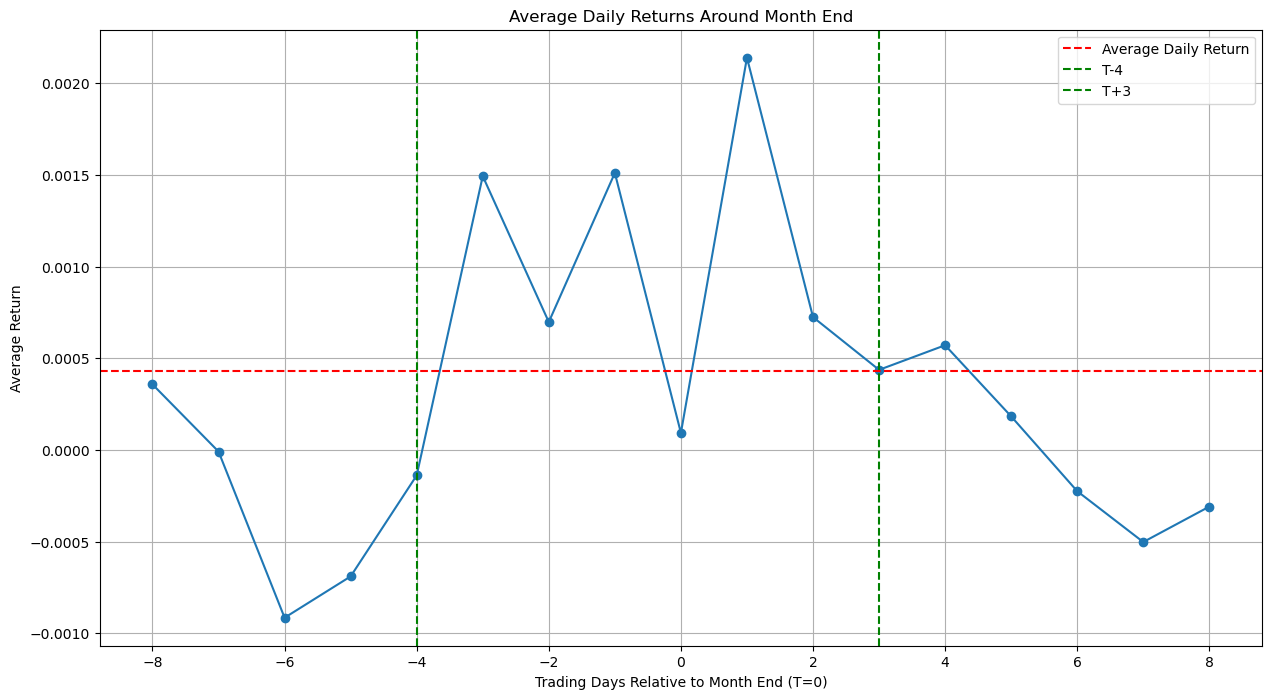

In [94]:
# Calculate Period Returns
# Define the periods according to the paper
daily_vw_returns['period'] = 'other'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-8, -4), 'period'] = 'T-8_to_T-4'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(-3, -1), 'period'] = 'T-3_to_T-1'
daily_vw_returns.loc[daily_vw_returns['trading_day'] == 0, 'period'] = 'T_0'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(1, 3), 'period'] = 'T_1 to_T+3'
daily_vw_returns.loc[daily_vw_returns['trading_day'].between(4, 8), 'period'] = 'T+4_to_T+8'

# Calculate average returns by period
period_stats = daily_vw_returns.groupby('period')['vw_ret'].agg(['mean', 'std', 'count'])
avg_daily_ret = daily_vw_returns['vw_ret'].mean()

# Calculate abnormal returns
period_stats['abnormal_ret'] = period_stats['mean'] - avg_daily_ret
period_stats['t_stat'] = (period_stats['abnormal_ret'] * np.sqrt(period_stats['count']) / 
                         period_stats['std'])
period_stats['p_value'] = 2 * (1 - stats.t.cdf(abs(period_stats['t_stat']), 
                                              period_stats['count'] - 1))

print("\nPeriod Statistics:")
print(period_stats)

# plot the graph
plt.figure(figsize=(15, 8))
daily_means = daily_vw_returns.groupby('trading_day')['vw_ret'].mean()
plt.plot(daily_means.index, daily_means.values, marker='o')
plt.axhline(y=avg_daily_ret, color='r', linestyle='--', label='Average Daily Return')
plt.axvline(x=-4, color='g', linestyle='--', label='T-4')
plt.axvline(x=3, color='g', linestyle='--', label='T+3')
plt.title('Average Daily Returns Around Month End')
plt.xlabel('Trading Days Relative to Month End (T=0)')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
# loading the macro news data

# loading the CPI data
cpi = pd.read_excel('data/CPI.xlsx')
cpi = cpi[cpi['Event']== 'CPI MoM'].sort_values('Date Time')
# keep only the date
cpi['Date'] = pd.to_datetime(cpi['Date Time']).dt.date
# Retain only the relevant columns and drop duplicates
cpi = cpi[['Date', 'Actual', 'Survey']].drop_duplicates()
# rename the columns
cpi = cpi.rename(columns={
    'Survey': 'Survey_Value',
    'Actual': 'Actual_Value'
})
# add the announcement type
cpi['Announcement_Type'] = 'CPI'

# loading the FOMC data
FOMC = pd.read_excel('data/FOCM.xlsx')
FOMC = FOMC[FOMC['Event']== 'FOMC Rate Decision (Upper Bound)'].sort_values('Date Time')
FOMC['Date'] = pd.to_datetime(FOMC['Date Time']).dt.date
FOMC = FOMC[['Date', 'Actual', 'Surv(M)', 'Surprise']].drop_duplicates()
FOMC = FOMC.rename(columns={
    'Surv(M)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
FOMC['Announcement_Type'] = 'FOMC'

# loading the unemployment data
unemployment = pd.read_excel('data/Unemployment.xlsx')
unemployment = unemployment[unemployment['Event']== 'Unemployment Rate'].sort_values('Date Time')
unemployment['Date'] = pd.to_datetime(unemployment['Date Time']).dt.date
unemployment = unemployment[['Date', 'Actual', 'Surv(M)', 'Surprise']].drop_duplicates()
unemployment = unemployment.rename(columns={
    'Surv(M)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
unemployment['Announcement_Type'] = 'Unemployment'

In [101]:
macro_announcements

,Date,Actual_Value,Survey_Value,Announcement_Type,Surprise,announcement_count
0,1996-12-12,0.003,0.003,CPI,NaN,1
1,1997-01-10,0.053,0.053,Unemployment,0,1
2,1997-01-15,0.003,0.003,CPI,NaN,1
3,1997-02-07,--,--,Unemployment,--,1
4,1997-02-20,0.001,0.003,CPI,NaN,1
...,...,...,...,...,...,...
847,2024-12-18,0.045,0.045,FOMC,0,1
848,2025-01-15,0.004,0.004,CPI,NaN,1
849,2025-01-29,0.045,0.045,FOMC,--,1
850,2025-02-12,0.005,0.003,CPI,NaN,1


In [96]:
# 1. First concatenate all announcements
macro_announcements = pd.concat([cpi, FOMC, unemployment], ignore_index=True)
macro_announcements = macro_announcements.sort_values('Date')

# 2. Create pivot table
macro_pivot = macro_announcements.pivot_table(
    index='Date',
    columns='Announcement_Type',
    values=['Actual_Value', 'Survey_Value'],
    aggfunc='first'
).reset_index()

# 3. Fix the column names
macro_pivot.columns = ['date'] + ['_'.join(col).strip() for col in macro_pivot.columns[1:]]  # Changed 'Date' to 'date'

# 4. Add indicator columns
macro_pivot['has_cpi'] = macro_pivot['Actual_Value_CPI'].notna().astype(int)
macro_pivot['has_fomc'] = macro_pivot['Actual_Value_FOMC'].notna().astype(int)
macro_pivot['has_unemployment'] = macro_pivot['Actual_Value_Unemployment'].notna().astype(int)

# 5. Count announcements
macro_pivot['total_announcements'] = (
    macro_pivot['has_cpi'] + 
    macro_pivot['has_fomc'] + 
    macro_pivot['has_unemployment']
)

# 6. Create combination dummies
macro_pivot['cpi_fomc_day'] = (
    (macro_pivot['has_cpi'] == 1) & 
    (macro_pivot['has_fomc'] == 1)
).astype(int)

macro_pivot['cpi_unemp_day'] = (
    (macro_pivot['has_cpi'] == 1) & 
    (macro_pivot['has_unemployment'] == 1)
).astype(int)

macro_pivot['triple_announcement'] = (
    (macro_pivot['total_announcements'] == 3)
).astype(int)

# 7. Ensure dates are in datetime format
macro_pivot['date'] = pd.to_datetime(macro_pivot['date'])
daily_vw_returns['date'] = pd.to_datetime(daily_vw_returns['date'])

# 8. Merge with returns data
returns_with_announcements = daily_vw_returns.merge(
    macro_pivot,
    on='date',  # Using 'date' instead of 'Date'
    how='left'
)

# 9. Fill NaN values for announcement indicators
announcement_columns = ['has_cpi', 'has_fomc', 'has_unemployment', 
                       'cpi_fomc_day', 'cpi_unemp_day', 'triple_announcement']
returns_with_announcements[announcement_columns] = returns_with_announcements[announcement_columns].fillna(0)

# 10. Print summary to verify the merge
print("Summary of merged data:")
print("\nTotal number of trading days:", len(returns_with_announcements))
print("\nDays with announcements:")
for col in announcement_columns:
    print(f"{col}: {returns_with_announcements[col].sum()} days")

print("\nSample of days with multiple announcements:")
print(returns_with_announcements[returns_with_announcements['total_announcements'] > 1].head())

Summary of merged data:

Total number of trading days: 7174

Days with announcements:
has_cpi: 323.0 days
has_fomc: 220.0 days
has_unemployment: 277.0 days
cpi_fomc_day: 17.0 days
cpi_unemp_day: 0.0 days
triple_announcement: 0.0 days

Sample of days with multiple announcements:
           date    vw_ret    month next_month  trading_day      period  \
790  1998-08-18  0.016448  1998-08    1998-08          NaN       other   
854  1998-11-17  0.003034  1998-11    1998-11         -8.0  T-8_to_T-4   
1230 2000-05-16  0.013580  2000-05    2000-05          NaN       other   
2066 2003-09-16  0.013437  2003-09    2003-09          NaN       other   
3325 2008-09-16  0.014903  2008-09    2008-09          NaN       other   

     Actual_Value_CPI Actual_Value_FOMC Actual_Value_Unemployment  \
790             0.002             0.055                       NaN   
854             0.002            0.0475                       NaN   
1230                0             0.065                       NaN   


In [104]:
is_ret = returns_with_announcements.loc[returns_with_announcements['date'].between('1995-07-01', '2013-12-31')]
oos_ret = returns_with_announcements.loc[returns_with_announcements['date'].between('2014-01-01', '2023-12-31')]

0        True
1        True
2        True
3        True
4        True
        ...  
7169    False
7170    False
7171    False
7172    False
7173    False
Name: date, Length: 7174, dtype: bool

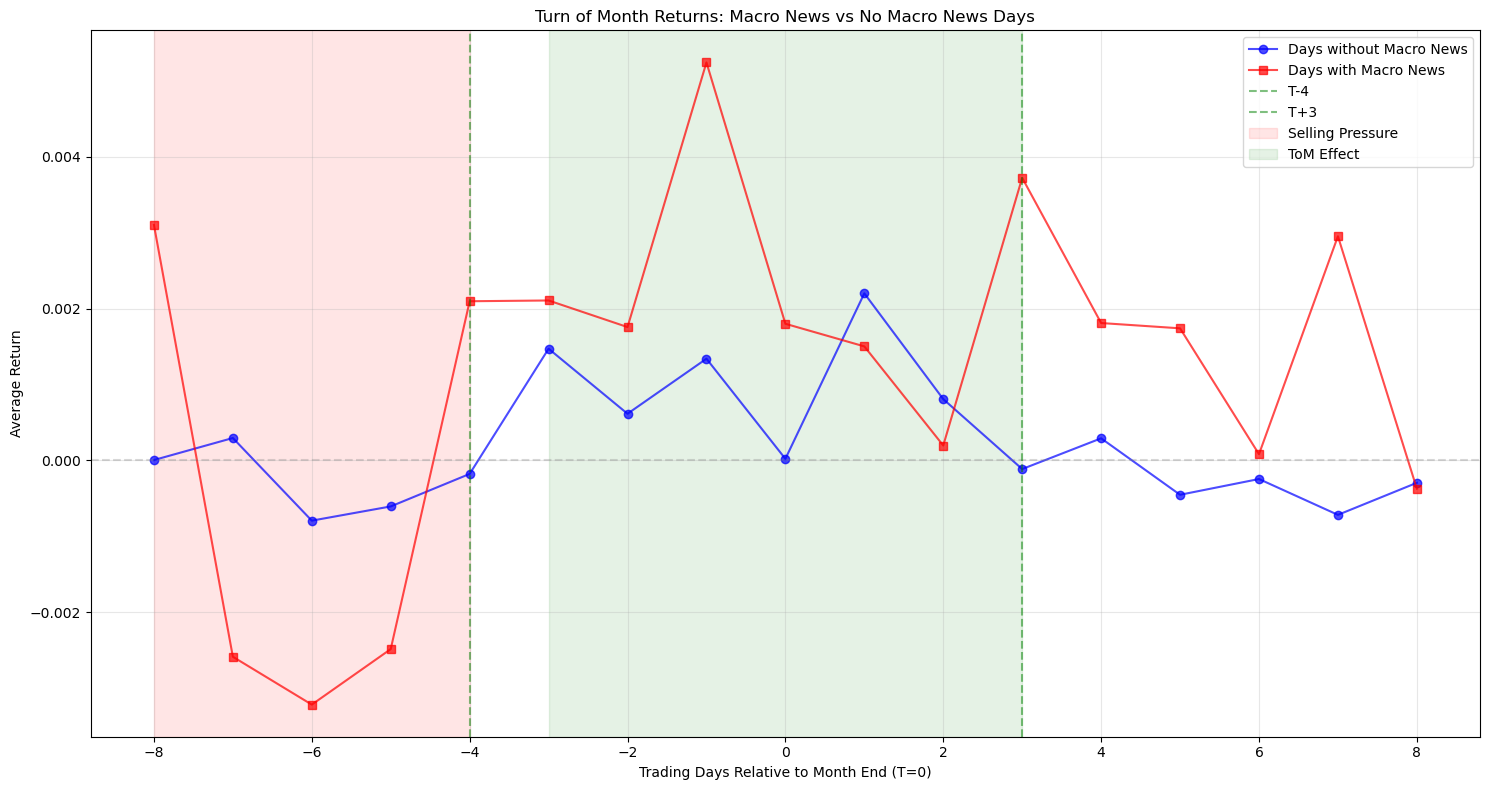


Statistical Summary by Period and Macro News:
                          Period  Macro_Mean(%)  Macro_t  Non_Macro_Mean(%)  \
0  Selling Pressure (T-8 to T-4)        -0.0456  -0.3664            -0.0266   
1         Early ToM (T-3 to T-1)         0.2843   1.8320             0.1148   
2                Month End (T=0)         0.1799   0.9120             0.0020   
3       Early Month (T+1 to T+3)         0.1891   1.6775             0.0990   
4          Post ToM (T+4 to T+8)         0.1242   1.4976            -0.0292   

   Non_Macro_t  Difference(%)  N_Macro  N_Non_Macro  
0      -0.9319        -0.0190      113         1597  
1       3.0162         0.1695       52          974  
2       0.0343         0.1779       14          328  
3       2.4660         0.0902      125          898  
4      -0.9579         0.1534      262         1441  

T-tests for differences between Macro and Non-Macro days:

Selling Pressure (T-8 to T-4):
t-statistic: -0.1690
p-value: 0.8658

Early ToM (T-3 to T-1):
t

In [97]:
# 1. First, merge the returns data with macro announcements
# Convert float indicators to boolean for logical operations
returns_with_announcements['has_macro_news'] = (
    (returns_with_announcements['has_cpi'].astype(bool) | 
     returns_with_announcements['has_fomc'].astype(bool) | 
     returns_with_announcements['has_unemployment'].astype(bool))
).astype(int)

is_ret = returns_with_announcements.loc[returns_with_announcements['date'].between('1995-07-01', '2013-12-31')]
oos_ret = returns_with_announcements.loc[returns_with_announcements['date'].between('2014-01-01', '2023-12-31')]



In [ ]:
def plot_macro(ret):
    # 2. Calculate average returns by trading day, split by macro news
    macro_day_returns = ret[ret['has_macro_news'] == 1]
    non_macro_day_returns = ret[ret['has_macro_news'] == 0]

    macro_means = macro_day_returns.groupby('trading_day')['vw_ret'].mean()
    non_macro_means = non_macro_day_returns.groupby('trading_day')['vw_ret'].mean()

    # 3. Create the plot
    plt.figure(figsize=(15, 8))

    # Plot returns for days with and without macro news
    plt.plot(non_macro_means.index, non_macro_means.values, 
            marker='o', label='Days without Macro News', color='blue', alpha=0.7)
    plt.plot(macro_means.index, macro_means.values, 
            marker='s', label='Days with Macro News', color='red', alpha=0.7)

    # Add reference lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=-4, color='green', linestyle='--', label='T-4', alpha=0.5)
    plt.axvline(x=3, color='green', linestyle='--', label='T+3', alpha=0.5)

    # Shade the key periods
    plt.axvspan(-8, -4, alpha=0.1, color='red', label='Selling Pressure')
    plt.axvspan(-3, 3, alpha=0.1, color='green', label='ToM Effect')

    # Customize the plot
    plt.title('Turn of Month Returns: Macro News vs No Macro News Days')
    plt.xlabel('Trading Days Relative to Month End (T=0)')
    plt.ylabel('Average Return')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # 4. Print statistical summary
    print("\nStatistical Summary by Period and Macro News:")
    periods = {
        'Selling Pressure (T-8 to T-4)': (-8, -4),
        'Early ToM (T-3 to T-1)': (-3, -1),
        'Month End (T=0)': (0, 0),
        'Early Month (T+1 to T+3)': (1, 3),
        'Post ToM (T+4 to T+8)': (4, 8)
    }

    stats_df = []
    for period_name, (start, end) in periods.items():
        # For macro news days
        macro_period = macro_day_returns[
            macro_day_returns['trading_day'].between(start, end)
        ]['vw_ret']
        
        # For non-macro news days
        non_macro_period = non_macro_day_returns[
            non_macro_day_returns['trading_day'].between(start, end)
        ]['vw_ret']
        
        # Calculate statistics
        stats_df.append({
            'Period': period_name,
            'Macro_Mean(%)': macro_period.mean() * 100,
            'Macro_t': (macro_period.mean() / (macro_period.std() / np.sqrt(len(macro_period)))),
            'Non_Macro_Mean(%)': non_macro_period.mean() * 100,
            'Non_Macro_t': (non_macro_period.mean() / (non_macro_period.std() / np.sqrt(len(non_macro_period)))),
            'Difference(%)': (macro_period.mean() - non_macro_period.mean()) * 100,
            'N_Macro': len(macro_period),
            'N_Non_Macro': len(non_macro_period)
        })

    stats_df = pd.DataFrame(stats_df)
    print(stats_df.round(4))

    # 5. Test for differences
    from scipy import stats

    print("\nT-tests for differences between Macro and Non-Macro days:")
    for period_name, (start, end) in periods.items():
        macro_ret = macro_day_returns[
            macro_day_returns['trading_day'].between(start, end)
        ]['vw_ret']
        
        non_macro_ret = non_macro_day_returns[
            non_macro_day_returns['trading_day'].between(start, end)
        ]['vw_ret']
        
        if len(macro_ret) > 0 and len(non_macro_ret) > 0:
            t_stat, p_val = stats.ttest_ind(macro_ret, non_macro_ret)
            print(f"\n{period_name}:")
            print(f"t-statistic: {t_stat:.4f}")
            print(f"p-value: {p_val:.4f}")

In [86]:
# Run regression with announcement effects
import statsmodels.api as sm

# Create interaction terms
returns_with_announcements['tom_macro_interaction'] = (
    returns_with_announcements['is_tom_effect'] * 
    (returns_with_announcements['total_announcements'] > 0)
)

returns_with_announcements['selling_macro_interaction'] = (
    returns_with_announcements['is_selling_pressure'] * 
    (returns_with_announcements['total_announcements'] > 0)
)

# Run regression
X = sm.add_constant(returns_with_announcements[[
    'is_tom_effect', 
    'is_selling_pressure',
    'has_cpi',
    'has_fomc',
    'has_unemployment',
    'tom_macro_interaction',
    'selling_macro_interaction'
]])

model = sm.OLS(returns_with_announcements['vw_ret'], X).fit(
    cov_type='HAC', 
    cov_kwds={'maxlags': 5}
)

print("\nRegression Results:")
print(model.summary().tables[1])


Regression Results:
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0003      0.000      1.180      0.238      -0.000       0.001
is_tom_effect                 0.0006      0.000      1.773      0.076   -6.21e-05       0.001
is_selling_pressure          -0.0005      0.000     -1.497      0.134      -0.001       0.000
has_cpi                       0.0002      0.001      0.233      0.816      -0.001       0.002
has_fomc                      0.0037      0.001      3.097      0.002       0.001       0.006
has_unemployment              0.0018      0.001      1.942      0.052   -1.71e-05       0.004
tom_macro_interaction        -0.0017      0.001     -1.371      0.170      -0.004       0.001
selling_macro_interaction    -0.0021      0.001     -1.398      0.162      -0.005       0.001


In [98]:
# merge the three data 
macro_announcements = pd.concat([cpi, FOMC, unemployment], ignore_index=True)
macro_announcements = macro_announcements.sort_values('Date')

# Create count of announcements per day
announcement_counts = macro_announcements.groupby('Date').size().reset_index(name='announcement_count')
macro_announcements = macro_announcements.merge(announcement_counts, on='Date')

#  create a pivot table to handle multiple announcements per date
macro_pivot = macro_announcements.pivot_table(
    index='Date',
    columns='Announcement_Type',
    values=['Actual_Value', 'Survey_Value'],
    aggfunc='first'  # takes the first value if there are duplicates
).reset_index()

In [99]:
# Flatten the column names
macro_pivot.columns = ['_'.join(col).strip() for col in macro_pivot.columns.values]

# Add indicator columns for each type of announcement
macro_pivot['has_cpi'] = macro_pivot['Actual_Value_CPI'].notna().astype(int)
macro_pivot['has_fomc'] = macro_pivot['Actual_Value_FOMC'].notna().astype(int)
macro_pivot['has_unemployment'] = macro_pivot['Actual_Value_Unemployment'].notna().astype(int)

# Count total announcements per day
macro_pivot['total_announcements'] = (
    macro_pivot['has_cpi'] + 
    macro_pivot['has_fomc'] + 
    macro_pivot['has_unemployment']
)

# Print summary statistics
print("Summary of Multiple Announcements:")
print("\nDays with multiple announcements:")
print(macro_pivot['total_announcements'].value_counts().sort_index())

print("\nCombinations of announcements:")
combinations = macro_pivot.groupby(
    ['has_cpi', 'has_fomc', 'has_unemployment']
).size().reset_index(name='count')
combinations.columns = ['CPI', 'FOMC', 'Unemployment', 'Count']
print(combinations)

Summary of Multiple Announcements:

Days with multiple announcements:
total_announcements
1    816
2     18
Name: count, dtype: int64

Combinations of announcements:
   CPI  FOMC  Unemployment  Count
0    0     0             1    282
1    0     1             0    212
2    1     0             0    322
3    1     1             0     18


In [100]:
# Create dummy variables for different combinations
macro_pivot['cpi_fomc_day'] = (
    (macro_pivot['has_cpi'] == 1) & 
    (macro_pivot['has_fomc'] == 1)
).astype(int)

macro_pivot['cpi_unemp_day'] = (
    (macro_pivot['has_cpi'] == 1) & 
    (macro_pivot['has_unemployment'] == 1)
).astype(int)

macro_pivot['triple_announcement'] = (
    (macro_pivot['total_announcements'] == 3)
).astype(int)

# Merge with your returns data
# Convert date format to match your returns data if needed
macro_pivot['Date'] = pd.to_datetime(macro_pivot['Date'])

# Now you can merge with your returns data
daily_vw_returns['date'] = pd.to_datetime(daily_vw_returns['date'])
returns_with_announcements = daily_vw_returns.merge(
    macro_pivot,
    left_on='date',
    right_on='Date',
    how='left'
)

# Fill NaN values with 0 for announcement indicators
announcement_columns = ['has_cpi', 'has_fomc', 'has_unemployment', 
                       'cpi_fomc_day', 'cpi_unemp_day', 'triple_announcement']
returns_with_announcements[announcement_columns] = returns_with_announcements[announcement_columns].fillna(0)

KeyError: 'Date'

In [39]:
# convert the 'date' in daily_vw_returns to a date for merging
daily_vw_returns['date_only'] = daily_vw_returns['date'].dt.date

In [40]:
# Mark days with a CPI announcement
daily_vw_returns['is_cpi_day'] = daily_vw_returns['date_only'].isin(cpi['Date']).astype(int)

# Create dummies for different ToM periods based on trading_day
daily_vw_returns['is_selling_pressure'] = daily_vw_returns['trading_day'].between(-8, -4).astype(int)
daily_vw_returns['is_tom_effect'] = daily_vw_returns['trading_day'].between(-3, 3).astype(int)

# Create interaction terms between ToM effects and CPI announcement days
daily_vw_returns['tom_cpi_interaction'] = daily_vw_returns['is_tom_effect'] * daily_vw_returns['is_cpi_day']
daily_vw_returns['selling_cpi_interaction'] = daily_vw_returns['is_selling_pressure'] * daily_vw_returns['is_cpi_day']

In [41]:
# Run the regression with cpi dates
# Model 1: Basic ToM effects (without CPI)
x1 = sm.add_constant(daily_vw_returns[['is_tom_effect', 'is_selling_pressure']])
model1 = sm.OLS(daily_vw_returns['vw_ret'], x1).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

# Model 2: Adding the CPI dummy
x2 = sm.add_constant(daily_vw_returns[['is_tom_effect', 'is_selling_pressure', 'is_cpi_day']])
model2 = sm.OLS(daily_vw_returns['vw_ret'], x2).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

# Model 3: Including the interaction terms
x3 = sm.add_constant(daily_vw_returns[['is_tom_effect', 'is_selling_pressure', 
                                         'is_cpi_day', 'tom_cpi_interaction', 
                                         'selling_cpi_interaction']])
model3 = sm.OLS(daily_vw_returns['vw_ret'], x3).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

# Print regression summaries
print("\nModel 1: Basic ToM Effect")
print(model1.summary().tables[1])

print("\nModel 2: With CPI Announcement Effect")
print(model2.summary().tables[1])

print("\nModel 3: With Interactions")
print(model3.summary().tables[1])


Model 1: Basic ToM Effect
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0005      0.000      2.307      0.021    7.21e-05       0.001
is_tom_effect           0.0005      0.000      1.461      0.144      -0.000       0.001
is_selling_pressure    -0.0008      0.000     -2.228      0.026      -0.001   -9.35e-05

Model 2: With CPI Announcement Effect
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0005      0.000      2.360      0.018    8.45e-05       0.001
is_tom_effect           0.0004      0.000      1.394      0.163      -0.000       0.001
is_selling_pressure    -0.0008      0.000     -2.260      0.024      -0.001      -0.000
is_cpi_day             -0.0002      0.001     -0.321  

In [42]:
# 4. Summary Statistics
print("\nNumber of observations in each category:")
print("Total trading days:", len(daily_vw_returns))
print("CPI announcement days:", daily_vw_returns['is_cpi_day'].sum())
print("ToM effect days:", daily_vw_returns['is_tom_effect'].sum())
print("Selling pressure days:", daily_vw_returns['is_selling_pressure'].sum())
print("Days with both ToM and CPI:", (daily_vw_returns['tom_cpi_interaction']==1).sum())



Number of observations in each category:
Total trading days: 7174
CPI announcement days: 323
ToM effect days: 2391
Selling pressure days: 1710
Days with both ToM and CPI: 4


In [43]:
# Create a dummy variable indicating if the observation is post-2010
daily_vw_returns['post_2010'] = daily_vw_returns['date'].dt.year >= 2010

# Run regressions for pre-2010 and post-2010 periods
for period in [False, True]:
    subsample = daily_vw_returns[daily_vw_returns['post_2010'] == period]
    X = sm.add_constant(subsample[['is_tom_effect', 'is_selling_pressure', 
                                   'is_cpi_day', 'tom_cpi_interaction']])
    model = sm.OLS(subsample['vw_ret'], X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    print(f"\nResults for {'Post' if period else 'Pre'}-2010 Period:")
    print(model.summary().tables[1])


Results for Pre-2010 Period:
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0004      0.000      1.257      0.209      -0.000       0.001
is_tom_effect           0.0005      0.000      0.997      0.319      -0.000       0.001
is_selling_pressure    -0.0008      0.001     -1.607      0.108      -0.002       0.000
is_cpi_day          -8.497e-05      0.001     -0.074      0.941      -0.002       0.002
tom_cpi_interaction    -0.0011      0.005     -0.205      0.838      -0.012       0.010

Results for Post-2010 Period:
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0006      0.000      2.155      0.031    5.45e-05       0.001
is_tom_effect           0.0004      0.000      1.008      0